In [56]:
from importlib import reload
from astropy import units as u
from astropy import constants as const

import pandas as pd
import pandas as pandas
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import ticker
import matplotlib.colors
import matplotlib.ticker as mticker

from scipy.interpolate import UnivariateSpline

from src import astro530

In [2]:
saha_LTE = astro530.saha_LTE

In [3]:
astro530 = reload(astro530)

In [4]:
def Pe_calc(species=None,T=5000*u.K,Pg=100*u.dyne/u.cm**2,tol=1e-8,single = False):
    dPe = 2*tol
    
    try: ab_df
    except:
        init_Abundance()
    
    A_list = []
    single_element = False
    single_param = False
    
    try:
        if species == None:
            species = []
            for element in ab_df.element:
                A = (ab_df.loc[ab_df.element == element].A).values[0]
                if A != "-":# and A > tol:
                    species.append(element)
                    A_list.append(A)
    except:
        try:
            temp = species
            temp[0] = "K"
            for element in species:
                A = (ab_df.loc[ab_df.element == element].A).values[0]
                if A != "-":
                    A_list.append(A) 
                else:
                    A_list.append(0)
        except:
            element = species
            species = [species]
            A = (ab_df.loc[ab_df.element == element].A).values[0]
            if A != "-":
                A_list.append(A)
            else:
                A_list.append(0)
                
    try:
        Pg = Pg.to(u.dyne/u.cm**2)
        T = T.to(u.K)          
    except:
        Pg = Pg*u.dyne/u.cm**2
        T = T*u.K
                
    try: 
        Pg[0]
    except:
        single_param = True
        
    A_arr = np.array(A_list)
    
    Phi = init_Phi(species=species,T=T,dtype="array")
    #return Phi
    #A_arr = np.resize(A_arr,np.shape(Phi))
    #print(Phi)
    
    Pe = Pg.value*1/(1+A_arr[1])*np.sum(A_arr[2:])#calc_Pe(species=species,T=T,Pg = Pg, Phi = Phi)

    Pe_list = [Pe]
    
    
    if single_param:
        while dPe > tol:
            num = np.sum((A_arr*Phi/Pe)/(1+Phi/Pe))
            den = np.sum((A_arr*(1+(Phi/Pe)/(1+Phi/Pe))))

            Pe_new = Pg.value*num/den
            dPe = abs(Pe-Pe_new)/Pe_new
            Pe = Pe_new#.value
            Pe_list.append(Pe)
        if single:
            return Pe*Pg.unit
        else:
            return np.array(Pe_list)*Pg.unit
    else:
        n_param = len(Pg)
        Pe_list = Pe_list[0]
        Pe_list3 = []
        
        for i in range(n_param):
            Pe = Pe_list[i]
            Pe_list2 = []
            dPe = 2*tol
            
            while dPe > tol:
                num = np.sum((A_arr*Phi[:,i]/Pe)/(1+Phi[:,i]/Pe))
                den = np.sum((A_arr*(1+(Phi[:,i]/Pe)/(1+Phi[:,i]/Pe))))

                Pe_new = Pg[i].value*num/den
                dPe = abs(Pe-Pe_new)/Pe_new
                
                Pe = Pe_new#.value
                Pe_list2.append(Pe)
            if single:
                Pe_list3.append(Pe)
            else:
                Pe_list3.append(Pe_list2)
                
        return np.array(Pe_list3)*Pg.unit
    
def init_Abundance():
    global ab_df
    try:
        ab_df = pandas.read_csv("data/SolarAbundance.csv").fillna("-")
    except:
        ab_df = pandas.read_csv("../data/SolarAbundance.csv").fillna("-")
        
def init_Phi(species=["H"],T=5000*u.K,dtype = "df"):
    if dtype != "array" or dtype != "df":
        dtype = "array"
    if dtype == "df":
        data = [["species","Phi"]]
        for element in species:
            data.append([element,saha_LTE(species=element,temp=T)])
        #print(data[0])
        df = pandas.DataFrame(data=data[1:],
                        columns=data[0])
        return df
    elif dtype == "array":
        data = []
        for element in species:
            data.append(saha_LTE(species=element,temp=T))
        return np.array(data)
    

In [5]:
#Pe_calc(T=T.value,Pg=Pg.value,tol=1e-10,single=True)

In [6]:
Pe_calc(Pg=0.9821*349*u.dyn/u.cm**2)

<Quantity [0.33962977, 0.04615608, 0.12299728, 0.06805375, 0.09486641,
           0.07795428, 0.08728471, 0.08169592, 0.08489223, 0.08301338,
           0.08410051, 0.08346564, 0.08383441, 0.08361953, 0.08374451,
           0.08367175, 0.08371409, 0.08368944, 0.08370378, 0.08369544,
           0.08370029, 0.08369747, 0.08369911, 0.08369815, 0.08369871,
           0.08369839, 0.08369858, 0.08369847, 0.08369853, 0.08369849,
           0.08369852, 0.0836985 , 0.08369851, 0.08369851, 0.08369851,
           0.08369851, 0.08369851, 0.08369851] dyn / cm2>

In [7]:
init_Abundance()

In [8]:
partition = astro530.partition

In [50]:
openfile = open("data/VALIIIC_sci_e.txt","r")
openlines = openfile.readlines()
openfile.close()

table = []
for i,line in enumerate(openlines):
    data = line.split()
    if len(data) == 0: continue
    if data[0] == "#":
        if i == 0:
            header = data[1:]
        print(line)
        continue
    table.append(data)
    
table = np.array(table,dtype=float)

df = pd.DataFrame(table,columns = header)
df

# h     m     tau_500     T     V     n_H     n_e     Ptotal  Pgas/Ptotal  rho

# (km) (g cm )            (K)  (km/s) (cm^-3) (cm^-3) (dyn cm^-2)          (g cm^-3)



,h,m,tau_500,T,V,n_H,n_e,Ptotal,Pgas/Ptotal,rho
0,2543.0,0.000005,0.000000e+00,447000.0,11.28,1.005000e+09,1.205000e+09,0.1440,0.9896,2.349000e-15
1,2298.0,0.000005,3.712000e-08,141000.0,9.87,3.205000e+09,3.839000e+09,0.1470,0.9752,7.494000e-15
2,2290.0,0.000005,3.969000e-08,89100.0,9.82,5.041000e+09,5.961000e+09,0.1472,0.9614,1.179000e-14
3,2280.0,0.000005,4.491000e-08,50000.0,9.76,9.038000e+09,9.993000e+09,0.1477,0.9318,2.113000e-14
4,2274.0,0.000005,4.952000e-08,37000.0,9.73,1.201000e+10,1.318000e+10,0.1481,0.9102,2.808000e-14
5,2271.0,0.000005,5.234000e-08,32000.0,9.71,1.378000e+10,1.498000e+10,0.1483,0.8976,3.222000e-14
6,2267.0,0.000005,5.657000e-08,28000.0,9.70,1.567000e+10,1.677000e+10,0.1487,0.8840,3.665000e-14
7,2263.0,0.000005,6.124000e-08,25500.0,9.68,1.718000e+10,1.812000e+10,0.1491,0.8738,4.017000e-14
8,2255.0,0.000005,7.110000e-08,24500.0,9.64,1.797000e+10,1.881000e+10,0.1500,0.8698,4.203000e-14
9,2230.0,0.000006,1.030000e-07,24200.0,9.49,1.862000e+10,1.943000e+10,0.1530,0.8718,4.355000e-14


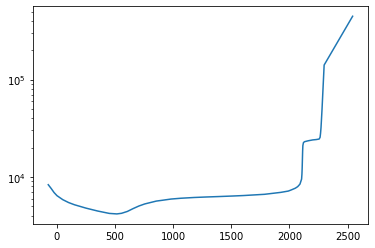

In [14]:
plt.yscale("log")
plt.plot(df["h"],df["T"])

In [15]:
Pe = ((df["n_e"]*df["T"]).to_numpy()*const.k_B.cgs).value
#partition(species="H",temp=df["T"])

In [16]:
Pe

array([7.43665874e-02, 7.47343923e-02, 7.33297338e-02, 6.89841273e-02,
       6.73287291e-02, 6.61827905e-02, 6.48297544e-02, 6.37942677e-02,
       6.36265188e-02, 6.49189444e-02, 6.65693722e-02, 6.87839332e-02,
       7.04641830e-02, 7.07030353e-02, 6.96426969e-02, 6.69200570e-02,
       5.61424348e-02, 5.22223581e-02, 4.85953932e-02, 4.42685221e-02,
       4.26902193e-02, 4.14705816e-02, 4.01033249e-02, 3.87257686e-02,
       3.81380539e-02, 3.85951040e-02, 4.36723164e-02, 5.33927343e-02,
       5.67788035e-02, 6.58956155e-02, 6.42870489e-02, 6.88449579e-02,
       7.79624325e-02, 8.51573948e-02, 8.33497111e-02, 8.29990953e-02,
       6.44274886e-02, 5.32239085e-02, 5.27988481e-02, 6.78594506e-02,
       1.01209718e-01, 1.43644793e-01, 2.63117459e-01, 6.84270354e-01,
       1.76470689e+00, 4.63148095e+00, 8.02851535e+00, 1.71096651e+01,
       5.70206104e+01, 1.47588203e+02, 4.88038021e+02, 1.38303476e+03])

In [17]:
const.k_B.cgs

<Quantity 1.380649e-16 erg / K>

In [18]:
n_p=astro530.saha_LTE(species="H",temp=df["T"],Pe=Pe)*df["n_H"].to_numpy()

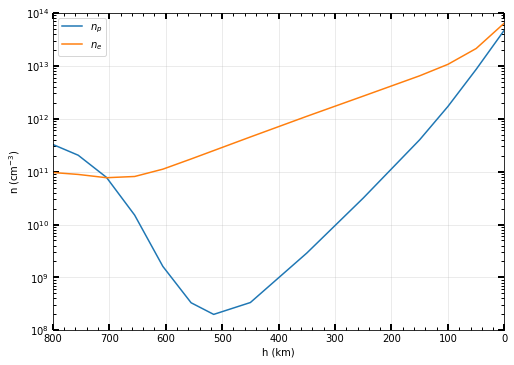

In [19]:
fig, ax = plt.subplots(figsize = (7,5), nrows = 1, ncols = 1)
fig.tight_layout(h_pad=-.5)

    
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

output_file = "plots/18b.pdf"
#label = r"$T = $"+str((T*u.g/u.g).value*u.K)+r" | log $P_g = $"+str(round(np.log10((Pg*u.g/u.g).value),2))+r" | log $P_e = $"+str(round(np.log10(Pe_arr[-1].value),2))
#ax.plot(i_arr,Pe_arr,lw=3,label=label)

ax.set_yscale("log")
ax.set_xlim([800,0])
ax.set_ylim([10**8,10**14])
ax.plot(df["h"],n_p,label=r"$n_p$")
ax.plot(df["h"],df["n_e"],label=r"$n_e$")

ax.set_xlabel("h (km)")
ax.set_ylabel(r"n (cm$^{-3}$)")

ax.legend()

fig.savefig(output_file,bbox_inches='tight')

In [20]:
h800 = df.loc[df["h"]<900].loc[df["h"]>740]
h800

,h,m,tau_500,T,V,n_H,n_e,Ptotal,Pgas/Ptotal,rho
35,855.0,0.002632,0.000016,5650.0,1.53,8.135000e+13,1.064000e+11,72.1,0.9691,1.902000e-10
36,755.0,0.005577,0.000025,5280.0,1.23,1.864000e+14,8.838000e+10,152.8,0.9784,4.358000e-10


In [21]:
pe = h800["n_e"].to_numpy()*h800["T"].to_numpy()*(const.k_B.cgs).value
T_arr = np.linspace(4500,5600,20)
prot=astro530.saha_LTE(species="H",temp=T_arr,Pe=pe.mean())*(h800["n_H"].to_numpy()).mean()
res = abs(prot-10**11)

<function matplotlib.pyplot.show(close=None, block=None)>

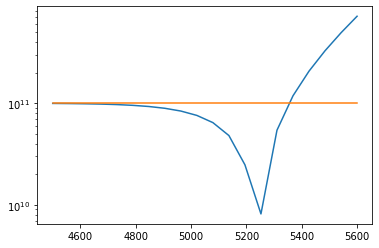

In [22]:
plt.plot(T_arr,res)
plt.plot([4500,5600],[10**11,10**11])
plt.yscale("log")
plt.show

In [23]:
minr= res[0]
mint = T_arr[0]
for i,r in enumerate(res):
    if r < minr:
        minr = r
        mint = T_arr[i]

In [24]:
init_Phi(species=["H","He"],T=np.array([5000,6000,7000]))[:,1]

array([3.50335526e-03, 8.23747106e-12])

In [25]:
# PeH=astro530.calc_Pe(species="H",T=df["T"].to_numpy()*u.K,Pg=df["Pgas/Ptotal"].to_numpy()*df["Ptotal"].to_numpy()*u.dyn/u.cm**2)
# PeFe=astro530.calc_Pe(species="Fe",T=df["T"].to_numpy()*u.K,Pg=df["Pgas/Ptotal"].to_numpy()*df["Ptotal"].to_numpy()*u.dyn/u.cm**2)
# PeMg=astro530.calc_Pe(species="Mg",T=df["T"].to_numpy()*u.K,Pg=df["Pgas/Ptotal"].to_numpy()*df["Ptotal"].to_numpy()*u.dyn/u.cm**2)
# PeSi=astro530.calc_Pe(species="Si",T=df["T"].to_numpy()*u.K,Pg=df["Pgas/Ptotal"].to_numpy()*df["Ptotal"].to_numpy()*u.dyn/u.cm**2)

In [26]:
# n_e = df["n_e"].loc[df["h"]<900].loc[df['h']>=-1]
# T = df["T"].loc[df["h"]<900].loc[df['h']>=-1].to_numpy()*u.K
# Pg = df["Pgas/Ptotal"].loc[df["h"]<900].loc[df['h']>=-1].to_numpy()*df["Ptotal"]
#.loc[df["h"]<900].loc[df['h']>=-1].to_numpy()*u.dyn/u.cm**2
n_e = df["n_e"].to_numpy()
T = df["T"].to_numpy()*u.K
Pg = df["Pgas/Ptotal"].to_numpy()*df["Ptotal"].to_numpy()*u.dyn/u.cm**2

In [27]:
Pe_true = []
Pe_2 = []
spec = ["H","He","Fe","Mg","Si"]
Pe_true = Pe_calc(T=T,Pg=Pg,tol = 1e-8,single=True)

In [28]:
AFe = astro530.find_Abundance(species="Fe")
AMg = astro530.find_Abundance(species="Mg")
ASi = astro530.find_Abundance(species="Si")

In [29]:
n_p=astro530.saha_LTE(species="H",temp=T,Pe=Pe_true)*df["n_H"].to_numpy()/(1+astro530.saha_LTE(species="H",temp=T,Pe=Pe_true))
n_Fe=astro530.saha_LTE(species="Fe",temp=T,Pe=Pe_true)*df["n_H"].to_numpy()*AFe/(1+astro530.saha_LTE(species="Fe",temp=T,Pe=Pe_true))
n_Mg=astro530.saha_LTE(species="Mg",temp=T,Pe=Pe_true)*df["n_H"].to_numpy()*AMg/(astro530.saha_LTE(species="Mg",temp=T,Pe=Pe_true)+1)
n_Si=astro530.saha_LTE(species="Si",temp=T,Pe=Pe_true)*df["n_H"].to_numpy()*ASi/(1+astro530.saha_LTE(species="Si",temp=T,Pe=Pe_true))

In [30]:
astro530.saha_LTE(species="Fe",temp=T,Pe=Pe_true)/(AFe*df["n_H"].to_numpy())

array([2.47156115e+08, 3.41887161e+06, 5.74448278e+05, 5.12330817e+04,
       1.32820586e+04, 6.67291150e+03, 3.44284918e+03, 2.12368464e+03,
       1.70020750e+03, 1.51936417e+03, 1.39019184e+03, 1.13612938e+03,
       9.49812997e+02, 8.27200265e+02, 5.58587858e+02, 2.68463147e+02,
       1.92227253e+01, 7.06104653e+00, 2.80308338e+00, 9.64537375e-01,
       6.28727124e-01, 3.91853900e-01, 2.09888549e-01, 9.56984650e-02,
       5.44326633e-02, 2.31750112e-02, 5.33889983e-03, 1.08100418e-03,
       4.78843152e-04, 1.38615472e-04, 5.28736571e-05, 1.97614861e-05,
       5.80634960e-06, 2.19711829e-06, 8.62025943e-07, 4.58149454e-07,
       1.03069944e-07, 3.98171849e-08, 9.65034104e-09, 1.10616226e-09,
       1.68300398e-10, 5.93324782e-11, 2.31789125e-11, 1.23032485e-11,
       8.68051548e-12, 7.76461783e-12, 8.29788299e-12, 9.43691111e-12,
       1.04320698e-11, 1.17030082e-11, 1.39203253e-11, 1.59735463e-11])

In [31]:
astro530.saha_LTE(species="H",temp=T,Pe=None)/Pe_true/df["n_H"].to_numpy()

<Quantity [3.47574347e+05, 2.84041549e+03, 3.04968408e+02, 1.05038315e+01,
           1.27124382e+00, 4.04073559e-01, 1.28494229e-01, 5.42261821e-02,
           3.64974459e-02, 3.08745356e-02, 2.72145464e-02, 2.02030247e-02,
           1.52782729e-02, 1.19828110e-02, 5.73559659e-03, 1.37217791e-03,
           5.12339651e-06, 5.03792830e-07, 5.56195081e-08, 4.56560174e-09,
           2.17336209e-09, 1.04916666e-09, 4.08771626e-10, 1.29010229e-10,
           5.64449805e-11, 1.76950166e-11, 2.55853652e-12, 3.80851920e-13,
           1.49929723e-13, 3.71496889e-14, 1.27427395e-14, 4.19661369e-15,
           1.00477503e-15, 3.04462546e-16, 8.46266377e-17, 3.59779072e-17,
           3.43370155e-18, 6.91935794e-19, 7.23584050e-20, 3.09887167e-21,
           2.40126671e-22, 6.75405225e-23, 3.18635955e-23, 4.01008477e-23,
           7.53806063e-23, 2.00895521e-22, 4.20754124e-22, 1.10345045e-21,
           3.55447032e-21, 8.55746693e-21, 2.55497923e-20, 6.36554857e-20] cm2 / dyn>

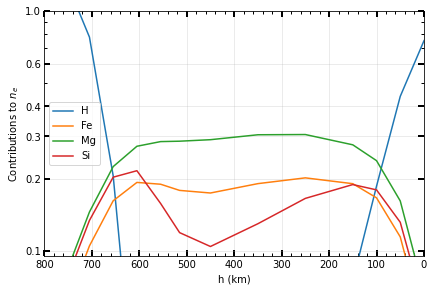

In [32]:
fig, ax = plt.subplots(figsize = (6,4), nrows = 1, ncols = 1)
fig.tight_layout(h_pad=-.5)

ax.set_xlim([800,0])
ax.set_ylim([0.095,10**0])

ax.set_yscale("log")


ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.set_yticks([0.1,0.2,0.3,0.4,.6,1])
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

#label = r"$T = $"+str((T*u.g/u.g).value*u.K)+r" | log $P_g = $"+str(round(np.log10((Pg*u.g/u.g).value),2))+r" | log $P_e = $"+str(round(np.log10(Pe_arr[-1].value),2))
#ax.plot(i_arr,Pe_arr,lw=3,label=label)

ax.plot(df["h"],n_p/n_e,label="H")
ax.plot(df["h"],n_Fe/n_e,label="Fe")
ax.plot(df["h"],n_Mg/n_e,label="Mg")
ax.plot(df["h"],n_Si/n_e,label="Si")
# ax.plot(df["h"],Pe,label=r"$P_{e,\mathrm{ideal}}$")
# ax.plot(df["h"],Pe_true,label=r"$P_{e,\mathrm{true}}$")

ax.set_xlabel("h (km)")
ax.set_ylabel(r"Contributions to $n_e$")

ax.legend()

output_file = "plots/18c.pdf"

fig.savefig(output_file,bbox_inches='tight')

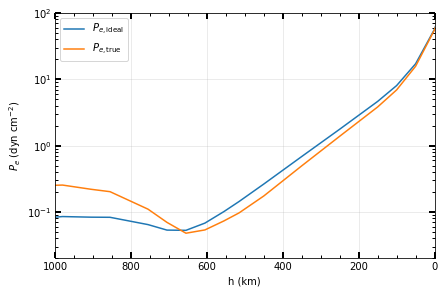

In [33]:
fig, ax = plt.subplots(figsize = (6,4), nrows = 1, ncols = 1)
fig.tight_layout(h_pad=-.5)

    
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

output_file = "plots/19a.pdf"
#label = r"$T = $"+str((T*u.g/u.g).value*u.K)+r" | log $P_g = $"+str(round(np.log10((Pg*u.g/u.g).value),2))+r" | log $P_e = $"+str(round(np.log10(Pe_arr[-1].value),2))
#ax.plot(i_arr,Pe_arr,lw=3,label=label)

ax.set_yscale("log")
ax.set_xlim([1000,0])
ax.set_ylim([0.02,10**2])
ax.plot(df["h"],Pe,label=r"$P_{e,\mathrm{ideal}}$")
ax.plot(df["h"],Pe_true,label=r"$P_{e,\mathrm{true}}$")

ax.set_xlabel("h (km)")
ax.set_ylabel(r"$P_e$ (dyn cm$^{-2}$)")

ax.legend()

fig.savefig(output_file,bbox_inches='tight')

In [34]:
sAjm=(2.2701*10**-24*u.g)

In [35]:
astro530.stim_em_coeff(wavelength=5000*u.Angstrom,T=6420*u.K)

0.9886916789247833

In [36]:
astro530.k_Hnbf(Pe=57*u.dyn/u.cm**2,T=6420*u.K,wavelength=5000*u.Angstrom)/sAjm

<Quantity 0.63401812 dyn / g>

In [37]:
astro530.k_e(Pe=57*u.dyn/u.cm**2,Pg=1.137e5*u.dyn/u.cm**2,species=["H","Fe","Mg","Si"])/sAjm

<Quantity 0.0001469 cm2 / g>

In [38]:
1.137e5*u.dyn/u.cm**2

<Quantity 113700. dyn / cm2>

In [39]:
astro530.k_total(Pe=57*u.dyn/u.cm**2,T=6420*u.K,wavelength=5000*u.Angstrom,species=["H","Fe","Mg","Si"])/sAjm

<Quantity 0.67280628 cm2 / g>

In [40]:
astro530.true_Pe(species=spec,T=6420*u.K,Pg = 1.137e5*u.dyn/u.cm**2,single=True)

<Quantity 54.55929459 dyn / cm2>

In [41]:
reload(astro530)

<module 'src.astro530' from 'C:\\Users\\xkncr\\Documents\\PSU\\Astro530\\src\\astro530.py'>

In [42]:
true_Pe = astro530.true_Pe

In [43]:
k_total = astro530.k_total

In [99]:
# def k_cont(wavelength=5000*u.Angstrom,T=5000*u.K,n_e=6e14*u.cm**-3,species="H",Pg=20*u.dyn/u.cm**2,print_bool = False,**kwargs):
#     sAjmu = 0
#     try:
#         ab_df
#     except:
#         try:
#             ab_df = pd.read_csv("data/SolarAbundance.csv").fillna("-")
#         except:
#             ab_df = pandas.read_csv("../data/SolarAbundance.csv").fillna("-")
    
#     amu = (const.N_A)**-1*1*u.g/u.mol        
    
#     if species == "all":
#         species = []
#         for element in ab_df.element:
#             A = (ab_df.loc[ab_df.element == element].A).values[0]
#             if A != "-" and A > 1e-10:
#                 species.append(element)
    
#     try:
#         for ele in species:
#             try:
#                 df_e = ab_df.loc[ab_df["element"]==ele]
#                 A = df_e.A.to_numpy()[0]
#                 mu = df_e.weight.to_numpy()[0]
#                 sAjmu += A*mu
#             except:
#                 raise ValueError(ele+" is not a valid element")
#     except:
#         try:
#             df_e = ab_df.loc[ab_df["element"]==species]
#             A = df_e.A.to_numpy()[0]
#             mu = df_e.weight.to_numpy()[0]
#             sAjmu += A*mu
#         except:
#             raise ValueError(ele+" is not a valid element")
#     Pe = true_Pe(species=species,T=T,Pg=Pg,single=True,**kwargs)
   
#     K_tot = k_total(Pe=Pe,T=T,wavelength=wavelength,Pg=Pg,species=species)
    
#     if print_bool:
#         print("T =",T)
#         print("P_e =",Pe)
#         print("P_g =",Pg)
#         print("Wavelength =",wavelength)
#         print("Mean particle mass =",sAjmu*amu)
#         print("Opacity =",K_tot/sAjmu/amu)
        
    
#     return K_tot/sAjmu/amu
def k_cont(wavelength=5000*u.Angstrom,T=5000*u.K,Pe=50*u.dyn/u.cm**2,Pg=2e5*u.dyn/u.cm**2,print_bool = False,**kwargs):

    sAjmu = abundance_mass()
    species = []
    for element in ab_df.element:
        A = (ab_df.loc[ab_df.element == element].A).values[0]
        if A != "-":
            species.append(element)
   
    K_tot = k_total(Pe=Pe,T=T,wavelength=wavelength,Pg=Pg,species=species)
    
    if print_bool:
        print("T =",T)
        print("P_e =",Pe)
        print("P_g =",Pg)
        print("Wavelength =",wavelength)
        print("Mean particle mass =",sAjmu*amu)
        print("Opacity =",K_tot/sAjmu/amu)
        
    
    return K_tot/sAjmu

def abundance_mass():
    sAjmu = 0
    try:
        ab_df
    except:
        init_Abundance()
    
    amu = (const.N_A)**-1*1*u.g/u.mol        
    
    species = []
    for element in ab_df.element:
        A = (ab_df.loc[ab_df.element == element].A).values[0]
        if A != "-":
            species.append(element)
    
    for ele in species:
        df_e = ab_df.loc[ab_df["element"]==ele]
        A = df_e.A.to_numpy()[0]
        mu = df_e.weight.to_numpy()[0]
        sAjmu += A*mu
        
    return sAjmu * amu

In [100]:
init_VAL()
k_alt

# h     m     tau_500     T     V     n_H     n_e     Ptotal  Pgas/Ptotal  rho

# (km) (g cm )            (K)  (km/s) (cm^-3) (cm^-3) (dyn cm^-2)          (g cm^-3)



<function __main__.k_alt(wavelength=<Quantity 5000. Angstrom>, T=<Quantity 5000. K>, Pe=<Quantity 50. dyn / cm2>, Pg=<Quantity 200000. dyn / cm2>, print_bool=False, **kwargs)>

In [101]:
val_df

,h,m,tau_500,T,V,n_H,n_e,Ptotal,Pgas/Ptotal,rho
0,2543.0,0.000005,0.000000e+00,447000.0,11.28,1.005000e+09,1.205000e+09,0.1440,0.9896,2.349000e-15
1,2298.0,0.000005,3.712000e-08,141000.0,9.87,3.205000e+09,3.839000e+09,0.1470,0.9752,7.494000e-15
2,2290.0,0.000005,3.969000e-08,89100.0,9.82,5.041000e+09,5.961000e+09,0.1472,0.9614,1.179000e-14
3,2280.0,0.000005,4.491000e-08,50000.0,9.76,9.038000e+09,9.993000e+09,0.1477,0.9318,2.113000e-14
4,2274.0,0.000005,4.952000e-08,37000.0,9.73,1.201000e+10,1.318000e+10,0.1481,0.9102,2.808000e-14
5,2271.0,0.000005,5.234000e-08,32000.0,9.71,1.378000e+10,1.498000e+10,0.1483,0.8976,3.222000e-14
6,2267.0,0.000005,5.657000e-08,28000.0,9.70,1.567000e+10,1.677000e+10,0.1487,0.8840,3.665000e-14
7,2263.0,0.000005,6.124000e-08,25500.0,9.68,1.718000e+10,1.812000e+10,0.1491,0.8738,4.017000e-14
8,2255.0,0.000005,7.110000e-08,24500.0,9.64,1.797000e+10,1.881000e+10,0.1500,0.8698,4.203000e-14
9,2230.0,0.000006,1.030000e-07,24200.0,9.49,1.862000e+10,1.943000e+10,0.1530,0.8718,4.355000e-14


In [102]:
k_alt

<function __main__.k_alt(wavelength=<Quantity 5000. Angstrom>, T=<Quantity 5000. K>, Pe=<Quantity 50. dyn / cm2>, Pg=<Quantity 200000. dyn / cm2>, print_bool=False, **kwargs)>

In [119]:
def opacity_500(tau=0.9,print_bool = False):
    try: val_df
    except:
        init_VAL()
    t500 = val_df.tau_500.to_numpy()
    T_arr = val_df["T"].to_numpy()
    Pg_arr = val_df.Ptotal.to_numpy()*val_df["Pgas/Ptotal"].to_numpy()
    
    T = UnivariateSpline(t500,T_arr,s=0,k=2)(tau)*u.K
    Pg = UnivariateSpline(t500,Pg_arr,s=0,k=2)(tau)*u.Ba
    
    Pe = Pe_calc(T=T,Pg=Pg,single=True)
    if print_bool:
        print("T:",T)
        print("Pg:",Pg)
        print("Pe:",Pe)
    
    return k_alt(wavelength=5000*u.Angstrom,T=T,Pg=Pg,Pe=Pe)
    
def init_VAL():
    global val_df
    try:
        openfile = open("data/VALIIIC_sci_e.txt","r")
    except:
        openfile = open("../data/VALIIIC_sci_e.txt","r")
    openlines = openfile.readlines()
    openfile.close()

    table = []
    for i,line in enumerate(openlines):
        data = line.split()
        if len(data) == 0: continue
        if data[0] == "#":
            if i == 0:
                header = data[1:]
            print(line)
            continue
        table.append(data)

    table = np.array(table,dtype=float)

    val_df = pd.DataFrame(table,columns = header)

In [129]:
opacity_500(tau=np.array([0.01,.5,0.9953]),print_bool=True)

T: [4544.26667018 5923.5397588  6420.        ] K
Pg: [  9585.00396863  85752.18461512 113707.44      ] Ba
Pe: [ 0.70918866 18.87501408 55.94222826] dyn / cm2


<Quantity [0.03347279, 0.30043227, 0.66062296] cm2 / g>

In [108]:
#astro530.k_total(Pe=10**2.76*u.Ba,T=11572*u.K,wavelength=1.5*u.um,Pg=1259*u.Ba,species="all")/(2.27e-24*u.g)

In [121]:
t_arr = np.logspace(-8,0.3,100)
k500 = opacity_500(tau=t_arr)

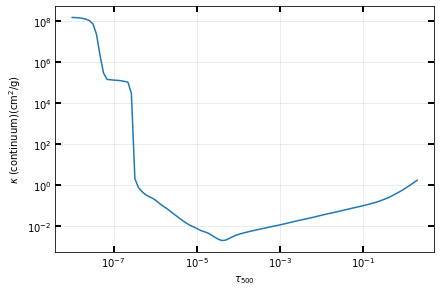

In [128]:
# plt.yscale("log")
# plt.xscale("log")
# plt.plot(t_arr,k500)

fig, ax = plt.subplots(figsize = (6,4), nrows = 1, ncols = 1)
fig.tight_layout(h_pad=-.5)

    
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

output_file = "plots/19d.pdf"
#label = r"$T = $"+str((T*u.g/u.g).value*u.K)+r" | log $P_g = $"+str(round(np.log10((Pg*u.g/u.g).value),2))+r" | log $P_e = $"+str(round(np.log10(Pe_arr[-1].value),2))
#ax.plot(i_arr,Pe_arr,lw=3,label=label)
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xlim([1000,0])
#ax.set_ylim([0.02,10**2])
ax.plot(t_arr,k500)

ax.set_xlabel(r"$\tau_{500}$")
ax.set_ylabel(r"$\kappa$ (continuum)(cm$^{2}$/g)")

#ax.legend()

fig.savefig(output_file,bbox_inches='tight')

In [163]:
dt = np.diff(val_df.tau_500.to_numpy())
t = val_df.tau_500.to_numpy()
dP = np.diff(val_df.Ptotal.to_numpy())
Ptot = val_df.Ptotal.to_numpy()
h = val_df.h.to_numpy()
T2 = []
t2 = []
P2 = []
h2 = []
for i in range(51):
    h2.append((h[i]+h[1+i])/2)
    t2.append((t[i]+t[i+1])/2)
    T2.append((T[i].value+T[i+1].value)/2)
    P2.append((Ptot[i]+Ptot[i+1])/2)
t2 = np.array(t2)
T2 = np.array(T2)
P2 = np.array(P2)
K = opacity_500(t2)
g= 10**4.4377

In [164]:
k = g*dt/dP * u.cm**2/u.g

In [174]:
rel_error = abs(K-k)/k

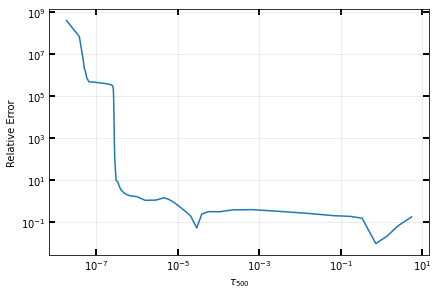

In [179]:
# plt.yscale("log")
# plt.xscale("log")
# plt.plot(t_arr,k500)

fig, ax = plt.subplots(figsize = (6,4), nrows = 1, ncols = 1)
fig.tight_layout(h_pad=-.5)

    
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

output_file = "plots/19e.pdf"
#label = r"$T = $"+str((T*u.g/u.g).value*u.K)+r" | log $P_g = $"+str(round(np.log10((Pg*u.g/u.g).value),2))+r" | log $P_e = $"+str(round(np.log10(Pe_arr[-1].value),2))
#ax.plot(i_arr,Pe_arr,lw=3,label=label)
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xlim([1000,0])
#ax.set_ylim([0.02,10**2])
ax.plot(t2,rel_error)

ax.set_xlabel(r"$\tau_{500}$")
ax.set_ylabel(r"Relative Error")

#ax.legend()

fig.savefig(output_file,bbox_inches='tight')

In [176]:
rel_error

<Quantity [4.03228043e+08, 6.91560844e+07, 2.24083204e+07, 6.36884603e+06,
           2.15186698e+06, 1.43377694e+06, 7.21104461e+05, 4.85248860e+05,
           4.72020845e+05, 4.30144958e+05, 4.00755972e+05, 3.62205063e+05,
           3.20503033e+05, 2.53551986e+05, 1.11618861e+05, 1.38517805e+04,
           6.38590331e+02, 1.04987148e+02, 1.01598383e+01, 8.22942490e+00,
           5.45171067e+00, 3.50959899e+00, 2.56293245e+00, 2.12725891e+00,
           1.83542147e+00, 1.67936226e+00, 1.11987828e+00, 1.14000425e+00,
           1.14733613e+00, 1.31362354e+00, 1.49332734e+00, 1.25118052e+00,
           8.98451047e-01, 5.83837937e-01, 3.88281539e-01, 2.06233597e-01,
           5.44099902e-02, 2.50793800e-01, 3.25378456e-01, 3.21561950e-01,
           3.93808263e-01, 4.05062645e-01, 3.31676603e-01, 2.66616831e-01,
           2.07669248e-01, 1.94326086e-01, 1.58582197e-01, 9.86491340e-03,
           2.19396809e-02, 6.82405584e-02, 1.83402026e-01]>